In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [146]:
from numba import njit


maze = []
with open('maze.txt') as f:
    for line in f:
        maze.append(line.split())
maze = np.array(maze, dtype = int)



class Env():
    def __init__(self, maze, initial_pos, ending_pos):
        
        self.maze = maze
        if self.maze[*initial_pos] == 0:
            print('Invalid initial position')
        if self.maze[*ending_pos] == 0:
            print('Invalid final position')

        self.initial_pos = np.array(initial_pos)
        self.pos = np.copy(self.initial_pos)
        self.ending_pos = np.array(ending_pos)
        self.action_dict = {0: [-1,0], 1:[1,0], 2:[0,-1], 3:[0,1]}
        
        self.state_matrix = np.copy(self.maze)
        self.state_matrix[self.state_matrix == 1] = np.arange(np.sum(self.maze))
        self.visited = [self.state_matrix[*self.initial_pos]]
        #print(self.state_matrix,self.maze)


    def reset(self):
        self.pos = np.copy(self.initial_pos)
        self.visited = [self.state_matrix[*self.initial_pos]]
    
    def print(self):
        str = ""
        for i in range(self.maze.shape[0]):
            for j in range(self.maze.shape[1]):
                if i == self.pos[0] and j == self.pos[1]:
                    str += 'o'
                    continue
                if i == self.ending_pos[0] and j == self.ending_pos[1]:
                    str += 'x'
                    continue   
                if self.maze[i,j] == 0:
                    str += '#'
                elif self.maze[i,j] == 1:
                    str+= ' '
            str += '\n'
        print(str)

    
    def move(self, direction):
        new_pos = self.pos + np.array(direction)
        if np.all(new_pos >= 0) and  np.all(self.maze.shape-new_pos > 0) and self.maze[*new_pos] == 1:
            self.pos = np.copy(new_pos)
            self.visited.append(self.state_matrix[*self.pos])
            return -0.04 #reward
        else:
            return -0.75 #reward
            
    def get_state(self):
        return self.state_matrix[*self.pos]


    def step(self,direction):
        reward = 0
        reward += self.move(direction)
        state = self.get_state()
        if state in self.visited[:-1]:
            reward += -0.2
        ended = 0
        if np.all(self.pos == self.ending_pos):
            reward += 1
            ended = 1
            
        return state,reward,ended

env1 = Env(maze,[0,2],[10,9])
env1.print()

##o########
#    ##   #
### ### # #
#     # # #
# ##### # #
#   # # # #
# ### # # #
# #       #
# ### ### #
#       # #
#########x#



In [147]:
from tqdm.notebook import trange, tqdm

total_rewards = []
num_actions = 4
num_states = np.sum(env1.maze)
Q_table = 0*np.ones(shape = (num_states,num_actions))
n_episodes = 1000
max_iter_episode = 200
exploration_probability = 0.1
gamma = 0.7
lr = 0.1


for e in trange(n_episodes):
    
    done = False
    total_episode_reward = 0
    env1.reset()
    current_state = env1.get_state()
    for i in range(max_iter_episode): 
        if np.random.uniform(0,1) < exploration_probability:
            action = np.random.choice([0,1,2,3])
        else:
            action = np.argmax(Q_table[current_state,:])
        next_state, reward, done = env1.step(env1.action_dict[action])
        
        Q_table[current_state, action] = (1-lr) * Q_table[current_state, action] +lr*(reward + gamma*np.max(Q_table[next_state,:]))
        total_episode_reward += reward
        if total_episode_reward < -100 or done:
            break
        current_state = next_state
    total_rewards.append(total_episode_reward)


def test(Q_table):
    max_iter_episode = 100
    env1.reset()
    current_state = env1.get_state()
    for i in range(max_iter_episode): 
        print(env1.pos)
        env1.print()
        action = env1.action_dict[np.argmax(Q_table[current_state,:])]
        next_state, reward, done = env1.step(action)
        if done:
            break
        current_state = next_state
        



  0%|          | 0/1000 [00:00<?, ?it/s]

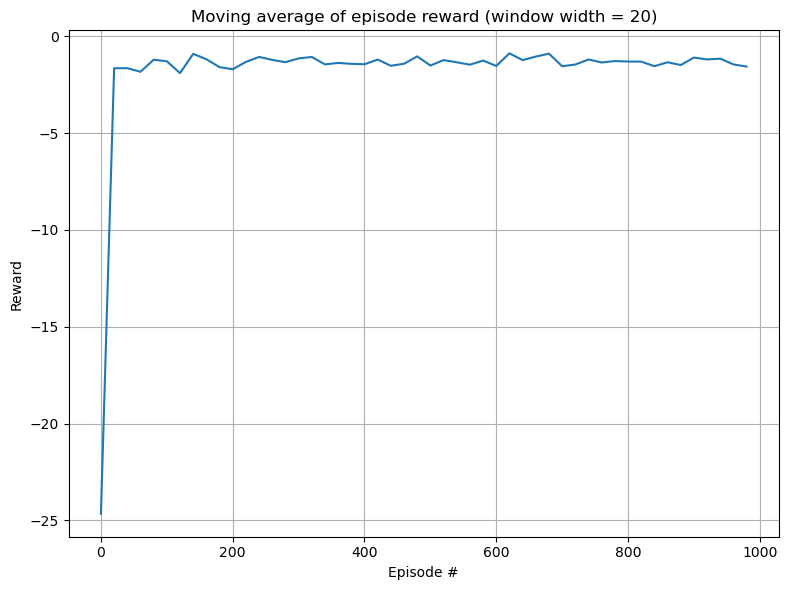

In [148]:
n_points = 50
step = n_episodes//n_points
rewards = [np.mean(total_rewards[i*step:(i+1)*step]) for i in range (n_points)]

plt.figure(figsize = (8,6))
plt.title(f'Moving average of episode reward (window width = {step})')
plt.plot(np.arange(0,n_episodes,step),rewards)
plt.ylabel("Reward")
plt.xlabel("Episode #")
plt.grid()
plt.tight_layout()
plt.show()

In [149]:
np.argmax(Q_table, axis = 1)

array([1, 3, 3, 1, 2, 3, 3, 1, 1, 0, 1, 1, 2, 2, 2, 1, 0, 1, 1, 0, 1, 1,
       2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 3, 3, 3, 3, 3, 1, 1, 0, 1, 3, 3,
       3, 3, 0, 2, 1, 1, 0])

In [150]:
test(Q_table)

[0 2]
##o########
#    ##   #
### ### # #
#     # # #
# ##### # #
#   # # # #
# ### # # #
# #       #
# ### ### #
#       # #
#########x#

[1 2]
## ########
# o  ##   #
### ### # #
#     # # #
# ##### # #
#   # # # #
# ### # # #
# #       #
# ### ### #
#       # #
#########x#

[1 3]
## ########
#  o ##   #
### ### # #
#     # # #
# ##### # #
#   # # # #
# ### # # #
# #       #
# ### ### #
#       # #
#########x#

[2 3]
## ########
#    ##   #
###o### # #
#     # # #
# ##### # #
#   # # # #
# ### # # #
# #       #
# ### ### #
#       # #
#########x#

[3 3]
## ########
#    ##   #
### ### # #
#  o  # # #
# ##### # #
#   # # # #
# ### # # #
# #       #
# ### ### #
#       # #
#########x#

[3 2]
## ########
#    ##   #
### ### # #
# o   # # #
# ##### # #
#   # # # #
# ### # # #
# #       #
# ### ### #
#       # #
#########x#

[3 1]
## ########
#    ##   #
### ### # #
#o    # # #
# ##### # #
#   # # # #
# ### # # #
# #       #
# ### ### #
#       # #
#########x#

[4 1]
## ########
#    ##  